In [1]:
using GRAPE
using QuantumControl
using LinearAlgebra
using QuantumPropagators: ExpProp
using Random

using Lattices
using LinearAlgebra
using Combinatorics
using SparseArrays
using Plots
import Graphs
using LaTeXStrings
using Statistics
using Random
using Zygote
# using Optimization, OptimizationOptimisers
using JSON
# using OptimizationOptimJL
# using ExponentialUtilities

QuantumControl.set_default_ad_framework(Zygote)

using QuantumControl.Functionals: make_chi, J_T_sm
using QuantumControl.Controls: get_controls, substitute

include("ed_objects.jl")
include("ed_functions.jl")
include("ed_optimization.jl")
include("utility_functions.jl")

┌ Info: QuantumControl: Setting Zygote as the default provider for automatic differentiation.
└ @ QuantumControl.Functionals C:\Users\jonat\.julia\packages\QuantumControl\51awt\src\functionals.jl:298


append_to_json_files (generic function with 1 method)

In [8]:


function create_fermionic_hamiltonian(subspace, indexer)

    time_dep_perturb = []
    dim = get_subspace_dimension(subspace)
    i = 0

    # single body interactions
    for σ1 in 1:2
        for σ2 in 1:2
            for s1 in unique(indexer.a)
                for s2 in unique(neighbors(subspace.lattice,s1))
                    if s1 > s2 # don't double count
                        continue
                    end
                    i += 1
                    
                    t_dict = Dict{Vector{Tuple{Coordinate{2,Int64},Int,Symbol}}, Float64}()
                    t_dict[[(s1, σ1,:create), (s2, σ2, :annihilate)]] = 0.1
                    # println("$i $([(s1, σ1,:create), (s2, σ2, :annihilate)])")
                    rows = Int[]
                    cols = Int[]
                    vals = Float64[]
                    general_n_body!(rows, cols, vals, t_dict, indexer)
                    # display(Matrix(sparse(rows, cols, vals, dim, dim)))
                    tmp_h = sparse(rows, cols, vals, dim, dim)
                    tmp_h = tmp_h + tmp_h'
                    # display(Matrix(tmp_h))
                    @eval $(Symbol("a$i"))(t) = 1.0
                    push!(time_dep_perturb, (tmp_h, @eval $(Symbol("a$i"))))
                end
            end
        end
    end
    return hamiltonian(spzeros(dim, dim), time_dep_perturb...)
end

half_filling = false
bc = "periodic"
N = 3
lattice_dimension = (3,1)
lattice = Square(lattice_dimension, if bc == "periodic" Periodic() else Open() end)
subspace = HubbardSubspace(N, lattice)
indexer = CombinationIndexer(reduce(vcat,collect(sites(subspace.lattice))), get_subspace_info(subspace)...)
H = create_fermionic_hamiltonian(subspace, indexer)
get_controls(H)

(Main.a1, Main.a2, Main.a3, Main.a4, Main.a5, Main.a6, Main.a7, Main.a8, Main.a9, Main.a10, Main.a11, Main.a12, Main.a13, Main.a14, Main.a15, Main.a16, Main.a17, Main.a18, Main.a19, Main.a20, Main.a21, Main.a22, Main.a23, Main.a24)

In [9]:
dim = get_subspace_dimension(subspace)
Nt = 20
tlist = collect(range(0, 1, length=Nt+1));

function onehot(k, dim)
    state = zeros(ComplexF64, dim)
    state[k] = 1
    state
end
function random_state(dim)
    normalize(rand(ComplexF64, dim))
end

function J_a(pulsevals::Vector{Float64}, tlist)
    dt = tlist[2] - tlist[1]
    # println(pulsevals)
    # println(norm(pulsevals,1))
    norm(pulsevals, 1)*dt
end

ψ0 = random_state(dim)
ψf = random_state(dim)
trajectories = [Trajectory(initial_state=ψ0, generator=H, target_state=ψf)];
chi_sm = make_chi(J_T_sm, trajectories; mode=:automatic, automatic=Zygote)

problem = ControlProblem(
    trajectories=trajectories,
    tlist=tlist,
    iter_stop=20,
    prop_method=ExpProp,
    pulse_options=Dict(),
    J_T=J_T_sm,
    J_a=J_a,
    lambda_a = 1e-4,
    # upper_bounds = (fill( 0.30, Nt), fill( 0.30, Nt)),  # example amplitude box
    # lower_bounds = (fill(-0.30, Nt), fill(-0.30, Nt)),
    # info_hook = GRAPE.make_grape_print_iters()   
);

result = optimize(problem; method=GRAPE)

┌ Info: make_grad_J_a for J_a=J_a: fallback to mode=:automatic
└ @ QuantumControl.Functionals C:\Users\jonat\.julia\packages\QuantumControl\51awt\src\functionals.jl:358
┌ Info: make_grad_J_a for J_a=J_a: automatic with Zygote
└ @ QuantumControl.Functionals C:\Users\jonat\.julia\packages\QuantumControl\51awt\src\functionals.jl:410


 iter.        J_T       ǁ∇Jǁ       ǁΔϵǁ         ΔJ   FG(F)    secs
     0   3.77e-01   1.67e-02        n/a        n/a    1(0)     7.9
     1   3.77e-01   1.67e-02   1.67e-02  -2.80e-04    1(0)     3.4
     2   2.86e-01   1.67e-02   4.14e+01  -8.96e-02    1(0)     4.8
     3   1.40e-01   1.82e-02   1.72e+01  -1.46e-01    1(0)     3.4
     4   1.21e-01   4.62e-03   4.80e+00  -1.89e-02    1(0)     4.0
     5   7.87e-02   3.62e-03   2.74e+01  -4.13e-02    1(0)     4.5
     6   6.87e-02   4.88e-03   5.41e+00  -9.83e-03    2(0)     7.5
     7   5.88e-02   4.39e-03   3.73e+00  -1.01e-02    1(0)     3.7
     8   3.56e-02   3.43e-03   1.55e+01  -2.26e-02    1(0)     3.7
     9   3.13e-02   2.21e-03   1.59e+01  -3.19e-03    1(0)     3.7
    10   2.47e-02   4.51e-03   3.81e+00  -6.89e-03    1(0)     3.3
    11   2.33e-02   1.22e-03   1.57e+00  -1.38e-03    1(0)     3.6
    12   2.03e-02   9.63e-04   5.03e+00  -2.77e-03    1(0)     4.3
    13   1.80e-02   1.05e-03   5.60e+00  -2.18e-03    1(0)    

GRAPE Optimization Result
-------------------------
- Started at 2025-09-05T10:35:42.867
- Number of trajectories: 1
- Number of iterations: 20
- Number of pure func evals: 0
- Number of func/grad evals: 22
- Value of functional: 1.15268e-02
- Reason for termination: Reached maximum number of iterations
- Ended at 2025-09-05T10:37:15.392 (1 minute, 32 seconds, 525 milliseconds)


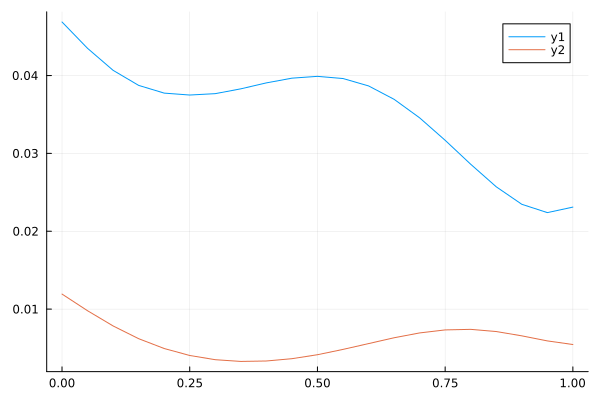

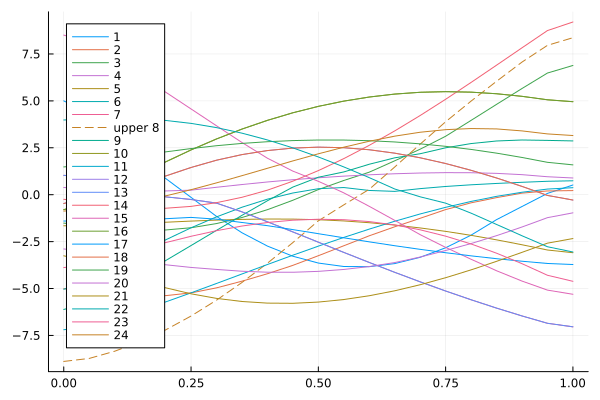

2.390773144847973
2.956660263049751
2.463372207093725
0.743753532126203
1.7812222935200015
1.3377798048043272
3.00196222699836
5.175094819560171
2.6602810846155798
3.7555056936538853
3.0983511186809936
1.3891831930830096
3.0019622269984194
2.954304325806873
3.8142131883351427
3.7555056936538813
2.269309378559906
1.3891831930830212
2.3595124127526654
3.199273760519286
4.527350756475299
2.475655772124586
2.5284753466709313
2.0046822697318105


In [10]:
using Plots
using QuantumControl.Controls: substitute
opt_dynamics = propagate_trajectory(
    substitute(trajectories[1], IdDict(zip(get_controls(trajectories), result.optimized_controls))),
    problem.tlist,
    method=ExpProp,
    storage=true,
    observables=(Ψ -> abs2.(Ψ),)
)
# display(result.optimized_controls)
p = plot()
for i in 1:2
    plot!(p, tlist, opt_dynamics[i, :])
end
display(p)

p = plot()
for i in 1:length(get_controls(trajectories))
    println(mean(abs.(result.optimized_controls[i] )))
    if mean(abs.(result.optimized_controls[i] )) > 5
        plot!(p, tlist, result.optimized_controls[i], linestyle=:dash, label="upper $i")
    else
        plot!(p, tlist, result.optimized_controls[i], label=i)
    end
end
display(p)